
# End-to-End Telco Customer Churn Prediction

This notebook implements an end-to-end churn prediction workflow on the **Telco Customer Churn** dataset:

- Business understanding
- Data loading & cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering
- Modeling with cross-validation
- Model comparison
- SHAP explainability
- Saving the best model for API & dashboard
- import warnings
warnings.filterwarnings("ignore")



In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import joblib

plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", 100)


In [13]:
!pip install xlrd


## 1. Load Data

In [15]:
import pandas as pd

df = pd.read_csv(r"D:\downloads\Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:

DATA_PATH = r"D:\downloads\Telco-Customer-Churn.csv"

assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}. Please check the path."

#df_raw = pd.read_excel(DATA_PATH) 
df_raw = pd.read_csv(r"D:\downloads\Telco-Customer-Churn.csv")
df_raw.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Basic Cleaning

In [20]:

df = df_raw.copy()

# Strip column names
df.columns = df.columns.str.strip()

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:

# Drop customerID if present
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Convert total charges to numeric if present
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values simply (median for numeric, mode for categorical)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.isna().sum().sort_values(ascending=False).head()


C:\Users\asiru\AppData\Local\Temp\ipykernel_2216\3683860719.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\asiru\AppData\Local\Temp\ipykernel_2216\3683860719.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

gender           0
SeniorCitizen    0
Partner          0
Dependents       0
tenure           0
dtype: int64

## 3. Define Target and Features

In [22]:

# Assume 'Churn' is the target with Yes/No
target_col = 'Churn'
assert target_col in df.columns, "Expected a 'Churn' column in the dataset."

df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})
y = df[target_col]
X = df.drop(columns=[target_col])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

len(num_cols), len(cat_cols), num_cols[:5], cat_cols[:5]


(4,
 15,
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines'])

## 4. Train / Test Split

In [23]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5634, 19), (1409, 19))

## 5. Preprocessing & Feature Engineering Pipeline

In [24]:

# Example feature engineering: tenure bucket if 'tenure' exists
def add_feature_engineering(df_in):
    df = df_in.copy()
    if 'tenure' in df.columns:
        df['tenure_bucket'] = pd.cut(
            df['tenure'],
            bins=[0, 12, 24, 48, 72],
            labels=['0-1 yr', '1-2 yrs', '2-4 yrs', '4-6 yrs'],
            include_lowest=True
        )
    return df

X_train_fe = add_feature_engineering(X_train)
X_test_fe = add_feature_engineering(X_test)

num_cols_fe = X_train_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_fe = X_train_fe.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_fe),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_fe),
    ]
)

preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 6. Modeling with Cross-Validation

In [26]:

models = {
    "log_reg": LogisticRegression(max_iter=1000, n_jobs=-1),
    "rf": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    ),
    "xgb": XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss", n_jobs=-1, random_state=42
    ),
    "lgbm": LGBMClassifier(
        n_estimators=300, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "catboost": CatBoostClassifier(
        depth=6, learning_rate=0.05, iterations=300,
        loss_function="Logloss", verbose=0, random_state=42
    ),
}

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(
        pipe,
        X_train_fe,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_estimator=True,
    )
    cv_results[name] = scores
    print(f"Model: {name}")
    print(
        "ROC-AUC: %.3f ± %.3f | F1: %.3f ± %.3f"
        % (
            scores["test_roc_auc"].mean(),
            scores["test_roc_auc"].std(),
            scores["test_f1"].mean(),
            scores["test_f1"].std(),
        )
    )
    print("-" * 60)


Model: log_reg
ROC-AUC: 0.846 ± 0.012 | F1: 0.594 ± 0.024
------------------------------------------------------------
Model: rf
ROC-AUC: 0.823 ± 0.012 | F1: 0.545 ± 0.024
------------------------------------------------------------
Model: xgb
ROC-AUC: 0.844 ± 0.009 | F1: 0.581 ± 0.027
------------------------------------------------------------
Model: lgbm
ROC-AUC: 0.837 ± 0.009 | F1: 0.579 ± 0.029
------------------------------------------------------------
Model: catboost
ROC-AUC: 0.843 ± 0.009 | F1: 0.579 ± 0.021
------------------------------------------------------------


## 7. Select Best Model & Evaluate on Test Set

In [27]:

best_model_name = None
best_score = -np.inf
best_estimator = None

for name, scores in cv_results.items():
    mean_roc = scores["test_roc_auc"].mean()
    if mean_roc > best_score:
        best_score = mean_roc
        best_model_name = name
        # Take the best performing estimator (by index of max roc_auc)
        best_idx = np.argmax(scores["test_roc_auc"])
        best_estimator = scores["estimator"][best_idx]

print("Best model:", best_model_name, "ROC-AUC:", best_score)

# Evaluate on test set
y_pred_proba = best_estimator.predict_proba(X_test_fe)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test F1:", f1_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Best model: log_reg ROC-AUC: 0.8464777737590625
Test ROC-AUC: 0.8422201555193882
Test F1: 0.562874251497006
Test Precision: 0.6394557823129252
Test Recall: 0.5026737967914439

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



## 8. SHAP Explainability

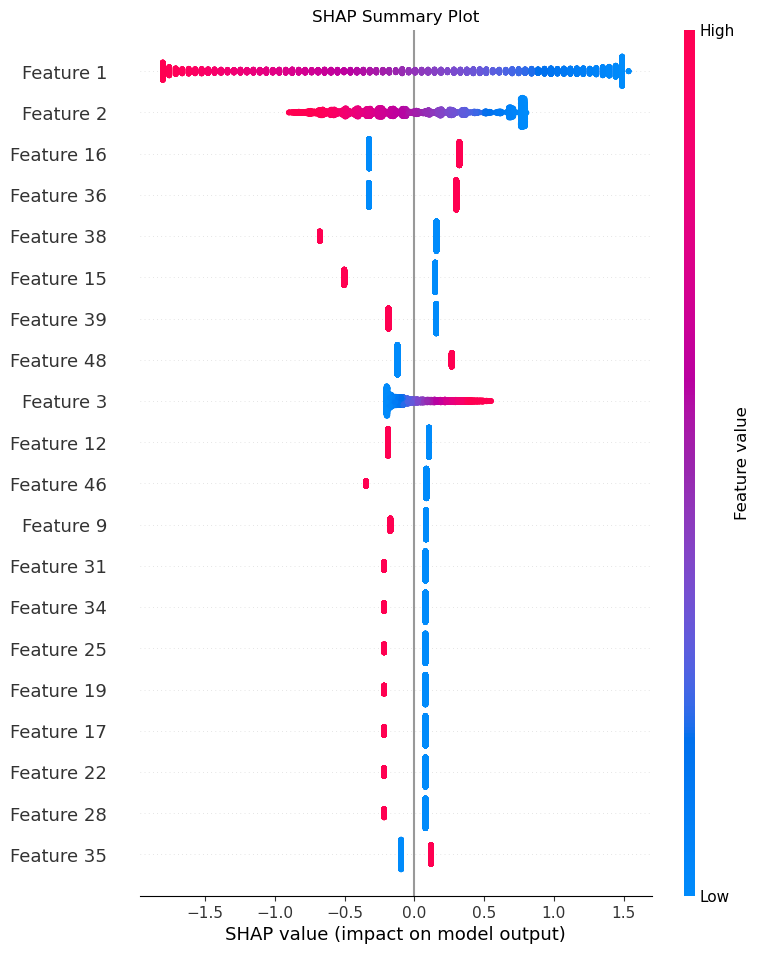

In [28]:

# Fit a fresh pipeline on full training data for SHAP (using best model)
best_model = models[best_model_name]
pipe_best = Pipeline(steps=[("preprocess", preprocess), ("model", best_model)])
pipe_best.fit(X_train_fe, y_train)

# We need transformed features for SHAP
X_train_trans = pipe_best.named_steps["preprocess"].transform(X_train_fe)

model_step = pipe_best.named_steps["model"]

explainer = shap.TreeExplainer(model_step) if hasattr(model_step, "feature_importances_") else shap.LinearExplainer(model_step, X_train_trans)
shap_values = explainer.shap_values(X_train_trans)

# Summary plot
shap.summary_plot(shap_values, X_train_trans, show=False)
plt.title("SHAP Summary Plot")
plt.show()


## 9. Save Best Model Pipeline

In [29]:

os.makedirs("models", exist_ok=True)
model_path = os.path.join("models", f"best_churn_model_{best_model_name}.joblib")
joblib.dump(pipe_best, model_path)
model_path


'models\\best_churn_model_log_reg.joblib'